In [59]:
"""
    load raw_data user_id item_id score
    train irt and save theta ,alpha, beta
    
"""
import json
import torch
from tqdm import tqdm
import numpy as np
from CAT.distillation.model import distillModel 
from CAT.distillation.tool import get_label_and_k, split_data, transform

dataset='assistment'
cdm='irt'
stg='MFI'
with_tested_info=False
postfix = '_with_tested_info' if with_tested_info else ''
trait = json.load(open(f'/data/yutingh/CAT/data/{dataset}/{stg}/trait{postfix}.json', 'r'))
utrait = trait['user']
itrait = trait['item']
label = trait['label']
k_info = trait['k_info']
# if 'tested_info' in trait:
if with_tested_info:
    tested_info= trait['tested_info']
    user_dim=np.array(tested_info).shape[-1]+1
else:
    user_dim=1
    
train_data, test_data = split_data(utrait,label,k_info,0.8)

torch.manual_seed(0)
train_set = transform(itrait,*train_data)
test_set = transform(itrait,*test_data)
k=50
embedding_dim=15
dMFI = distillModel(k,embedding_dim,user_dim,device='cuda:0')
postfix=''
dMFI.load(f'/data/yutingh/CAT/ckpt/{dataset}/{cdm}_{stg}_ip{postfix}.pt')
# dMFI.eval(test_set,itrait)
ball_embs=[]
max_embs_len=torch.tensor(0.)
for i in tqdm(itrait.items()):
    i_emb = dMFI.model.itn(torch.tensor(i[1]).to('cuda:0'))
    ball_embs.append(i_emb.tolist())
    i_emb_len = (i_emb**2).sum()
    if i_emb_len>max_embs_len:
        max_embs_len = i_emb_len



100%|██████████| 903/903 [00:00<00:00, 2553.68it/s]


In [60]:
import json
import numpy as np
from sklearn import manifold, datasets
import matplotlib.pyplot as plt
dataset='assistment'
stg='MFI'
postfix=''
ball_trait = ball_embs
trait = json.load(open(f'/data/yutingh/CAT/data/{dataset}/{stg}/trait.json', 'r'))
utrait = trait['user']
itrait = trait['item']
# label = trait['label']
k_info = trait['k_info']

In [61]:
k=10
i_label={}
for i in itrait.keys():
    i_label[int(i)]=[]
# print(i_label.keys())
for theta,top_k in zip(utrait.values(), k_info):
    for q in top_k[:k]:
        i_label[q].append(theta)
# cnt=0
# for k,v in i_label.items():
#     if len(v)>0:
#         cnt+=1
#     # print(k,len(v))
# print(cnt)
label=[sum(i)/len(i)  if len(i)!=0 else -3 for i in i_label.values()]
# label=[len(i) for i in i_label.values()]

In [56]:
min(label)

-3

/data/yutingh/miniconda3/envs/exp/lib/python3.9/site-packages/scikit_learn-1.1.2-py3.9-linux-x86_64.egg/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/data/yutingh/miniconda3/envs/exp/lib/python3.9/site-packages/scikit_learn-1.1.2-py3.9-linux-x86_64.egg/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


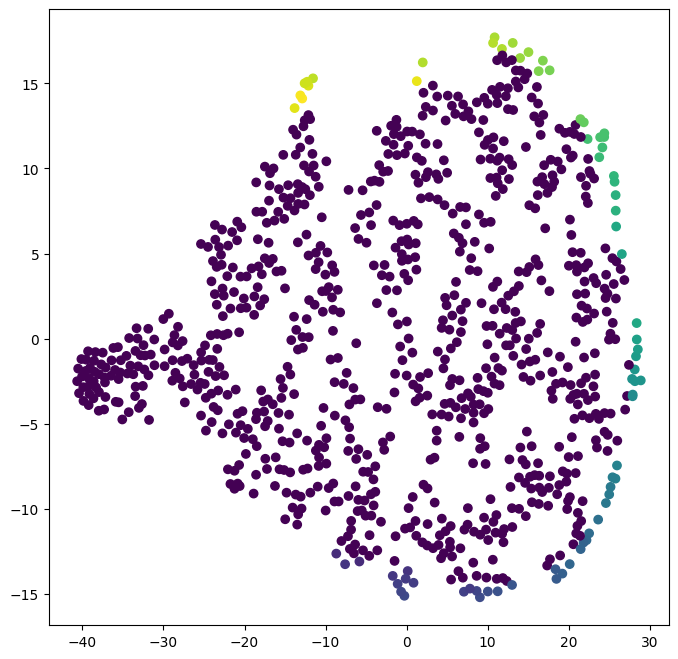

In [62]:
X = np.array(ball_trait)
tsne = manifold.TSNE(n_components=2,perplexity=50, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
plt.figure(figsize=(8, 8))
# plt.scatter(x=X_tsne[:,0], y=X_tsne[:,1])
plt.scatter(x=X_tsne[:,0], y=X_tsne[:,1],c=label,cmap="viridis")
